In [2]:
import pandas as pd

df = pd.read_csv('preprocessed_data_train_3.csv')
df.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM10510,Kota Jakarta Utara,Laki-laki,1983-09-11,2021-02-09,2023-06-22,Married,1,SLTA,9.0,...,Mid-term,2.800000,2,1,1418218.0,1,1.418218e+06,2.2,Medium,9.246870
1,EM4322,Kabupaten Bekasi,Perempuan,1987-03-22,2022-02-28,2023-04-04,Married,1,SLTA,0.0,...,Mid-term,13.000000,2,1,1060575.0,1,1.060575e+06,1.6,Medium,9.650000
2,EM1637,Kota Jakarta Barat,Laki-laki,1970-04-27,2020-12-23,2023-03-25,Married,4,D2,4.0,...,Mid-term,5.400000,5,1,4885136.0,3,1.628379e+06,1.0,Medium,9.813826
3,EM14613,Kota Jakarta Pusat,Laki-laki,1988-06-10,2022-11-21,2024-03-23,Married,1,D3,2.0,...,Mid-term,5.333333,2,1,4602479.0,4,1.150620e+06,2.4,Medium,9.756440
4,EM1084,Kabupaten Bogor,Perempuan,1977-05-25,2021-06-07,2023-07-21,Married,3,SLTA,0.0,...,Mid-term,25.000000,4,1,1066966.0,1,1.066966e+06,2.6,Medium,9.080000


In [3]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['resign_date'] = pd.to_datetime(df['resign_date'])

min_join_date = df['join_date'].min()
max_join_date = df['join_date'].max()

min_resign_date = df['resign_date'].min()
max_resign_date = df['resign_date'].max()

print("Join Date - Min:", min_join_date)
print("Join Date - Max:", max_join_date)
print("Resign Date - Min:", min_resign_date)
print("Resign Date - Max:", max_resign_date)

Join Date - Min: 2020-01-02 00:00:00
Join Date - Max: 2024-10-30 00:00:00
Resign Date - Min: 2020-05-05 00:00:00
Resign Date - Max: 2024-10-31 00:00:00


In [4]:
X = df.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y = df['active_work_months']

df['join_date'] = pd.to_datetime(df['join_date'])

train_data = df[df['join_date'] < '2023-01-01']
valid_data = df[df['join_date'] >= '2023-01-01']

X_train = train_data.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y_train = train_data['active_work_months']

X_valid = valid_data.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y_valid = valid_data['active_work_months']

cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
               'education', 'active_work_category', 'resign_risk_indicator', 'jenis_kelamin']

In [5]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    cat_features=cat_feature,
    loss_function='RMSE',  # Fungsi kerugian regresi, seperti RMSE atau MAE
    eval_metric='RMSE',    # Metrik evaluasi regresi
    verbose=200
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

0:	learn: 13.5942904	test: 23.3418347	best: 23.3418347 (0)	total: 191ms	remaining: 3m 10s
200:	learn: 2.2250306	test: 5.0068018	best: 5.0068018 (200)	total: 8.01s	remaining: 31.8s
400:	learn: 0.5799503	test: 2.2619679	best: 2.2619679 (400)	total: 16.9s	remaining: 25.2s
600:	learn: 0.3616911	test: 1.7906967	best: 1.7906967 (600)	total: 25.9s	remaining: 17.2s
800:	learn: 0.3091173	test: 1.6207404	best: 1.6207404 (800)	total: 34.6s	remaining: 8.6s
999:	learn: 0.2895548	test: 1.5407851	best: 1.5407851 (999)	total: 43s	remaining: 0us

bestTest = 1.540785132
bestIteration = 999



In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi pada data valid
y_pred = model.predict(X_valid)

# Menghitung metrik regresi
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

# Membuat dataframe hasil metrik
metrics = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "R2 Score": r2
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df

,Score
MSE,2.374019
MAE,0.902642
RMSE,1.540785
R2 Score,0.925505


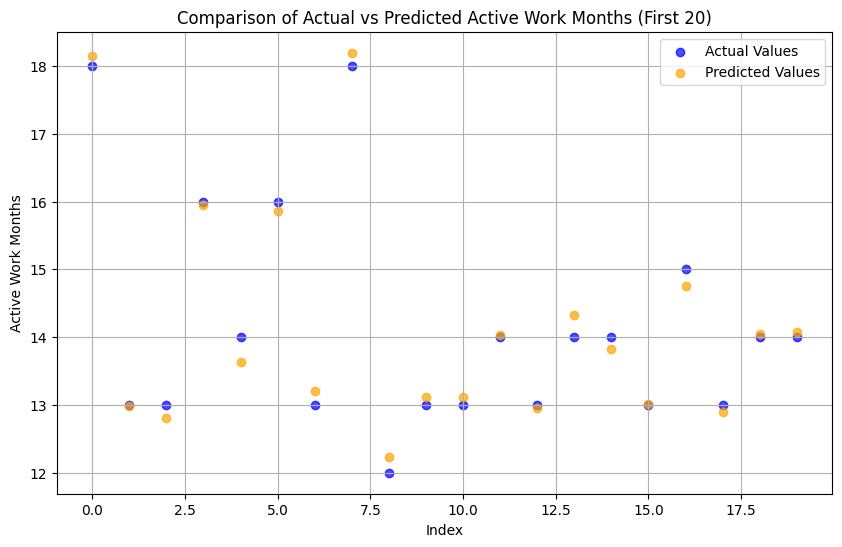

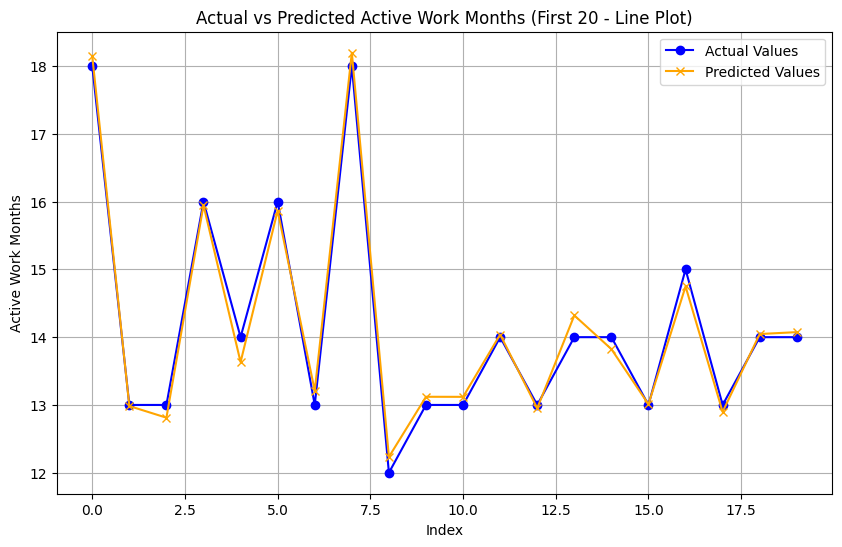

In [7]:
import matplotlib.pyplot as plt

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})

# Membatasi hanya pada 20 indeks pertama
comparison_df_subset = comparison_df.iloc[:20]

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months (First 20)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (First 20 - Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Fungsi objective untuk Optuna
def objective(trial):
    # Definisikan parameter yang akan dioptimasi
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 20),
        'random_strength': trial.suggest_float('random_strength', 5, 10),
        'cat_features': cat_feature,
        'loss_function': 'RMSE',  # Fungsi kerugian untuk regresi
        'random_state': 42,
        'verbose': 0
    }

    # Inisialisasi model dengan parameter yang dioptimasi
    model = CatBoostRegressor(**params)

    # Melatih model dengan validasi
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    # Prediksi nilai target
    y_pred = model.predict(X_valid)

    # Hitung RMSE
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    return rmse  # Mengembalikan RMSE sebagai skor yang ingin diminimalkan

# Membuat studi Optuna
study = optuna.create_study(direction="minimize")  # Minimalkan RMSE
study.optimize(objective, n_trials=20)

# Menampilkan hasil terbaik
print("Best trial:")
print(f"  RMSE: {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2025-01-31 22:03:50,597] A new study created in memory with name: no-name-474216de-e104-4659-8f4c-89a9d348bbe2
[I 2025-01-31 22:04:09,058] Trial 0 finished with value: 11.852841151612708 and parameters: {'iterations': 759, 'learning_rate': 0.0014964661109911665, 'depth': 4, 'subsample': 0.5345403763007321, 'colsample_bylevel': 0.5557879487166669, 'l2_leaf_reg': 14.523593619112225, 'random_strength': 5.436136126384264}. Best is trial 0 with value: 11.852841151612708.
[I 2025-01-31 22:04:26,185] Trial 1 finished with value: 2.782326827024678 and parameters: {'iterations': 631, 'learning_rate': 0.0688926002637438, 'depth': 4, 'subsample': 0.5589286667267055, 'colsample_bylevel': 0.5102559732260701, 'l2_leaf_reg': 12.03344970062869, 'random_strength': 7.74554502548946}. Best is trial 1 with value: 2.782326827024678.
[I 2025-01-31 22:04:40,370] Trial 2 finished with value: 6.727048715765419 and parameters: {'iterations': 543, 'learning_rate': 0.004111528098062327, 'depth': 4, 'subsample'

Best trial:
  RMSE: 2.3342054540264265
  Params: {'iterations': 831, 'learning_rate': 0.04518694466082468, 'depth': 6, 'subsample': 0.5547145239784439, 'colsample_bylevel': 0.6605692487332455, 'l2_leaf_reg': 5.931089190499905, 'random_strength': 9.381970152240088}


In [11]:
from sklearn.metrics import mean_squared_error

# Ambil parameter terbaik dari Optuna
best_params = study.best_trial.params

# Tambahkan parameter tetap (yang tidak dioptimasi)
best_params.update({
    'loss_function': 'RMSE',  # Gunakan RMSE sebagai loss function
    'cat_features': cat_feature,
    'random_state': 42,
    'verbose': 200,  # Aktifkan output verbose
    'od_type': 'Iter',
    'od_wait': 50
})

# Latih model dengan parameter terbaik
final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Evaluasi model final
y_pred = final_model.predict(X_valid)
final_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))  # Hitung RMSE
print(f"Final RMSE: {final_rmse}")

0:	learn: 13.2553205	test: 22.9596935	best: 22.9596935 (0)	total: 33.4ms	remaining: 27.7s
200:	learn: 0.9396532	test: 3.4434437	best: 3.4434437 (200)	total: 7.79s	remaining: 24.4s
400:	learn: 0.3768311	test: 2.5350476	best: 2.5350476 (400)	total: 18.5s	remaining: 19.8s
600:	learn: 0.3062632	test: 2.4067533	best: 2.4067533 (599)	total: 28s	remaining: 10.7s
800:	learn: 0.2733607	test: 2.3423564	best: 2.3423564 (800)	total: 37s	remaining: 1.39s
830:	learn: 0.2690607	test: 2.3342055	best: 2.3342055 (830)	total: 38.8s	remaining: 0us

bestTest = 2.334205454
bestIteration = 830

Final RMSE: 2.3342054540264265


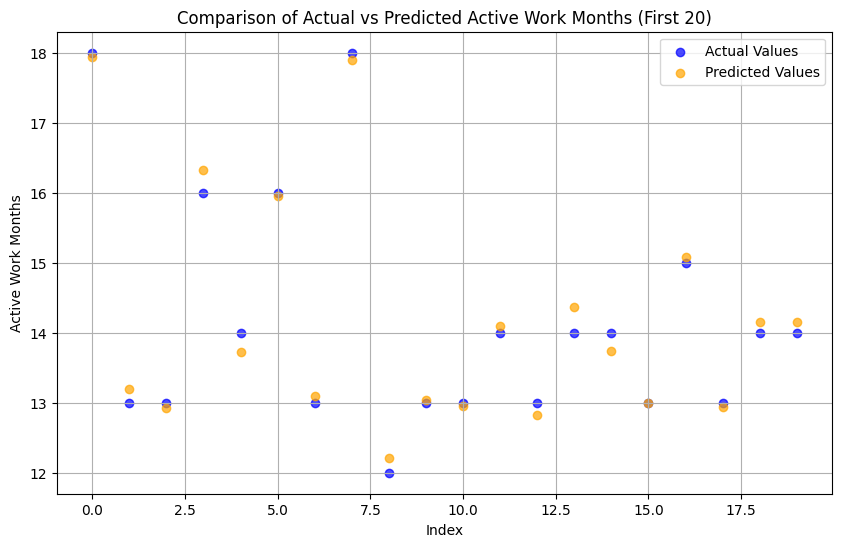

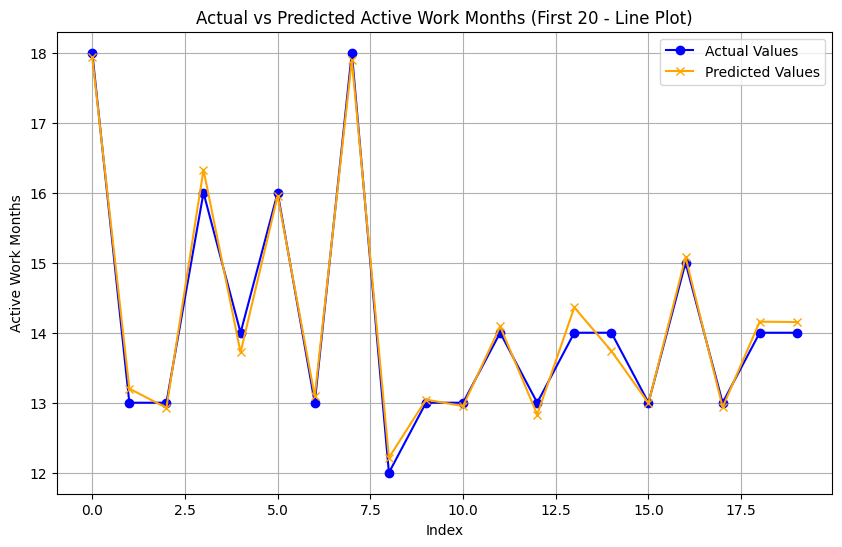

In [12]:
import matplotlib.pyplot as plt

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})

# Membatasi hanya pada 20 indeks pertama
comparison_df_subset = comparison_df.iloc[:20]

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months (First 20)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (First 20 - Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

Final Training RMSE: 0.28955484233140216
Final Validation RMSE: 1.5407851315191226


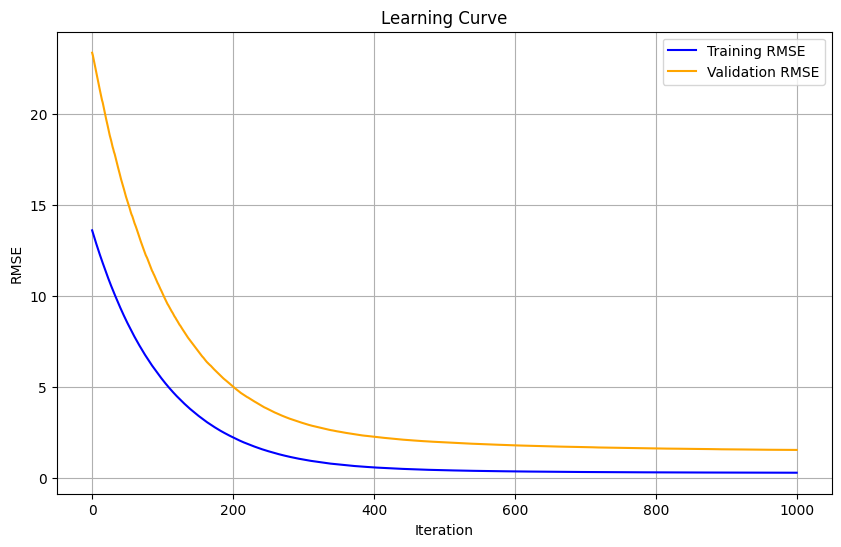

In [13]:
# Ambil hasil evaluasi dari model
evals_result = model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['RMSE'][-1]
val_score = evals_result['validation']['RMSE'][-1]

print(f"Final Training RMSE: {train_score}")
print(f"Final Validation RMSE: {val_score}")

# Import library untuk visualisasi
import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Final Training RMSE: 0.2690606507832273
Final Validation RMSE: 2.334205454026432


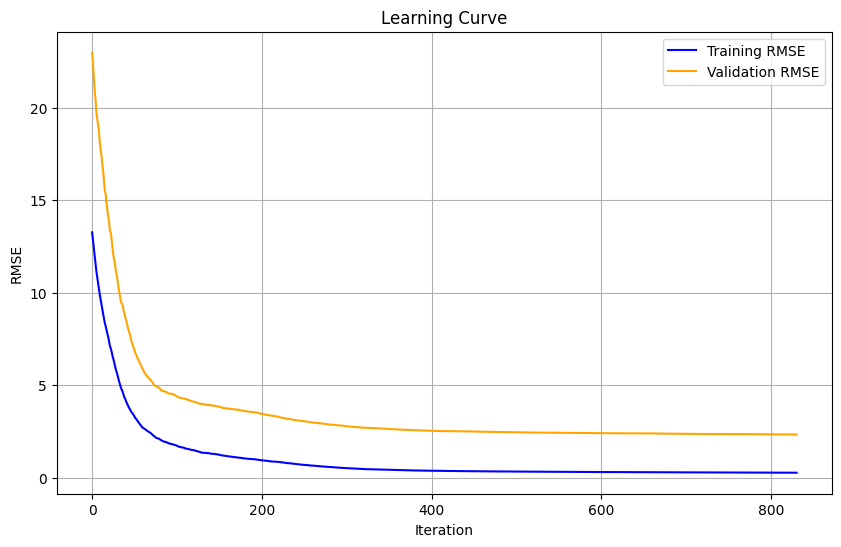

In [14]:
# Ambil hasil evaluasi dari model
evals_result = final_model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['RMSE'][-1]
val_score = evals_result['validation']['RMSE'][-1]

print(f"Final Training RMSE: {train_score}")
print(f"Final Validation RMSE: {val_score}")

# Import library untuk visualisasi
import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi pada data valid
y_pred = final_model.predict(X_valid)

# Menghitung metrik regresi
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

# Membuat dataframe hasil metrik
metrics = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "R2 Score": r2
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df

,Score
MSE,5.448515
MAE,1.116134
RMSE,2.334205
R2 Score,0.829029


In [16]:
import pickle

with open('regression_model.sav', 'wb') as f:
    pickle.dump(model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [17]:
import pickle

with open('regression_model_final.sav', 'wb') as f:
    pickle.dump(final_model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [18]:
# Mengurutkan data berdasarkan waktu (join_date)
df = df.sort_values('join_date')
X = df.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y = df['active_work_months']

0:	learn: 9.1646718	total: 29.5ms	remaining: 29.4s
200:	learn: 1.8381351	total: 6.45s	remaining: 25.7s
400:	learn: 0.6192440	total: 12.9s	remaining: 19.3s
600:	learn: 0.4141800	total: 19.9s	remaining: 13.2s
800:	learn: 0.3521180	total: 27.1s	remaining: 6.74s
999:	learn: 0.3155382	total: 35.7s	remaining: 0us
0:	learn: 9.8938338	total: 41.5ms	remaining: 41.4s
200:	learn: 1.8182014	total: 7.76s	remaining: 30.8s
400:	learn: 0.5997486	total: 15s	remaining: 22.4s
600:	learn: 0.4063431	total: 22.2s	remaining: 14.7s
800:	learn: 0.3487810	total: 30.2s	remaining: 7.51s
999:	learn: 0.3168919	total: 38s	remaining: 0us
0:	learn: 11.9438216	total: 34.6ms	remaining: 34.6s
200:	learn: 2.0373408	total: 8.97s	remaining: 35.7s
400:	learn: 0.5734042	total: 18.7s	remaining: 27.9s
600:	learn: 0.3694254	total: 28.3s	remaining: 18.8s
800:	learn: 0.3167774	total: 37.7s	remaining: 9.38s
999:	learn: 0.2925512	total: 47.9s	remaining: 0us
0:	learn: 13.7420148	total: 47.3ms	remaining: 47.2s
200:	learn: 2.2489494	to

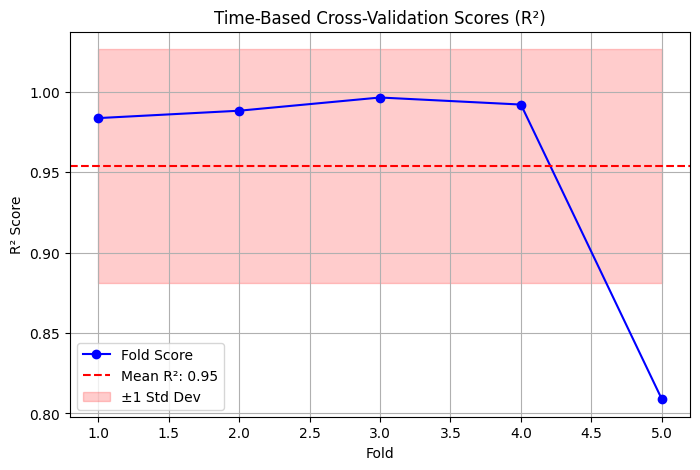

R² Scores for each fold: [0.98369199 0.9882848  0.99649707 0.99211623 0.80882796]
Mean R²: 0.95
Standard Deviation: 0.07


In [19]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menghitung skor cross-validation dengan TimeSeriesSplit
def time_series_cross_validate_and_visualize_r2(model, X, y, n_splits=5):
    # TimeSeriesSplit untuk data terkait waktu
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Hitung skor cross-validation dengan metrik R²
    scores = cross_val_score(model, X, y, scoring='r2', cv=tscv)

    # Rata-rata dan standar deviasi
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    # Visualisasi hasil cross-validation
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, n_splits + 1), scores, marker='o', linestyle='-', color='b', label='Fold Score')
    plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean R²: {mean_score:.2f}')
    plt.fill_between(range(1, n_splits + 1), mean_score - std_score, mean_score + std_score, color='r', alpha=0.2, label='±1 Std Dev')
    plt.title('Time-Based Cross-Validation Scores (R²)')
    plt.xlabel('Fold')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid()
    plt.show()

    # Cetak hasil skor
    print(f'R² Scores for each fold: {scores}')
    print(f'Mean R²: {mean_score:.2f}')
    print(f'Standard Deviation: {std_score:.2f}')

# Contoh penggunaan
time_series_cross_validate_and_visualize_r2(model, X, y, n_splits=5)

0:	learn: 9.0145461	total: 10.6ms	remaining: 8.78s
200:	learn: 1.2582659	total: 4.91s	remaining: 15.4s
400:	learn: 0.4363778	total: 11s	remaining: 11.8s
600:	learn: 0.3126921	total: 18.7s	remaining: 7.15s
800:	learn: 0.2545572	total: 25.5s	remaining: 957ms
830:	learn: 0.2481421	total: 26.5s	remaining: 0us
0:	learn: 9.6128998	total: 44ms	remaining: 36.5s
200:	learn: 0.8781166	total: 6.74s	remaining: 21.1s
400:	learn: 0.4015050	total: 15.2s	remaining: 16.3s
600:	learn: 0.3090510	total: 24.2s	remaining: 9.27s
800:	learn: 0.2592984	total: 31.9s	remaining: 1.2s
830:	learn: 0.2535358	total: 33.1s	remaining: 0us
0:	learn: 11.7063627	total: 17.1ms	remaining: 14.2s
200:	learn: 0.9246313	total: 7.73s	remaining: 24.2s
400:	learn: 0.4010091	total: 16.9s	remaining: 18.2s
600:	learn: 0.3216253	total: 26.5s	remaining: 10.1s
800:	learn: 0.2779483	total: 35.2s	remaining: 1.32s
830:	learn: 0.2736423	total: 36.6s	remaining: 0us
0:	learn: 13.3519464	total: 46.7ms	remaining: 38.7s
200:	learn: 0.9643347	tot

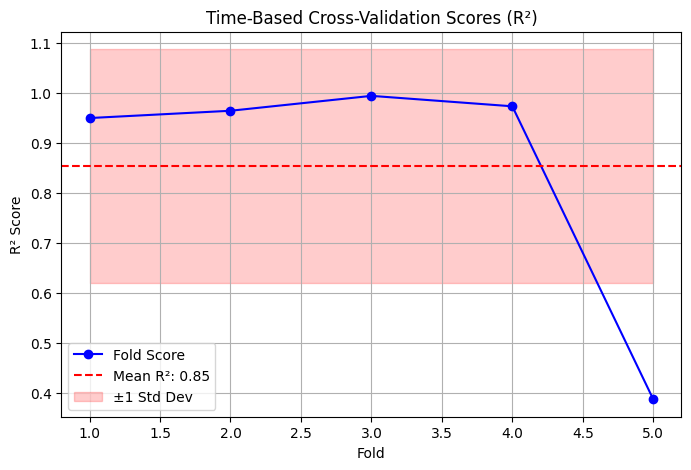

R² Scores for each fold: [0.95016289 0.96477909 0.99462171 0.97371542 0.38662643]
Mean R²: 0.85
Standard Deviation: 0.23


In [20]:
time_series_cross_validate_and_visualize_r2(final_model, X, y, n_splits=5)

# Testing

In [21]:
df_test = pd.read_csv('D:/Tugas Akhir/Codingan/Notebook - Playground/preprocessed_data_test_7.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM0406,Kota Jakarta Utara,Laki-laki,1975-01-07,2021-09-25,2023-12-07,Married,3,SLTA,3.0,...,Mid-term,6.500000,4,1,1578410.0,1,1578410.00,1.0,Medium,9.797428
1,EM1772,Kabupaten Bogor,Perempuan,1993-04-18,2021-02-23,2023-06-24,Married,1,SLTA,2.0,...,Mid-term,9.333333,2,1,2003154.0,1,2003154.00,2.2,Medium,9.342582
2,EM7996,Tangerang,Laki-laki,1998-02-12,2023-05-04,2024-06-29,Single,0,SLTA,5.0,...,Mid-term,2.333333,1,1,1394384.0,1,1394384.00,3.0,Medium,9.551975
3,EM13978,Kota Jakarta Barat,Perempuan,1982-12-26,2021-09-11,2023-04-03,Married,0,D3,0.0,...,Mid-term,18.000000,1,1,4151999.0,4,1037999.75,2.6,Medium,9.180000
4,EM9860,Tangerang,Perempuan,1997-03-26,2023-06-20,2024-10-02,Single,0,SLTA,15.0,...,Mid-term,0.937500,1,1,1560817.0,1,1560817.00,2.6,Medium,9.414301


In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9965371265802584
Mean Absolute Error (MAE): 0.3994272346412294
Mean Squared Error (MSE): 0.6346462447604223
Root Mean Squared Error (RMSE): 0.7966468758241774


In [23]:
df_test = pd.read_csv('D:/Tugas Akhir/Codingan/Notebook - Playground/preprocessed_data_test_5.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM0120,Tangerang,Laki-laki,1990-02-18,2023-01-11,2024-01-30,Married,1,SLTA,11.0,...,Mid-term,1.000000,2,1,1140915.0,1,1140915.0,1.4,Medium,9.393432
1,EM13985,Kepulauan Seribu,Perempuan,1987-02-01,2022-09-26,2023-11-08,Married,1,SLTA,0.0,...,Mid-term,13.000000,2,1,2103348.0,1,2103348.0,1.8,Medium,9.300000
2,EM2560,Tangerang,Perempuan,1999-11-01,2023-01-05,2024-05-04,Single,0,SLTA,10.0,...,Mid-term,1.454545,1,1,2145814.0,1,2145814.0,1.6,Medium,9.205670
3,EM0343,Kabupaten Bekasi,Laki-laki,1990-10-12,2022-02-01,2023-07-17,Single,0,SLTA,1.0,...,Mid-term,8.500000,1,1,2331081.0,1,2331081.0,2.6,Medium,9.154017
4,EM14458,Kabupaten Bogor,Perempuan,1996-04-24,2022-10-23,2023-12-30,Married,1,SLTA,12.0,...,Mid-term,1.076923,2,1,1798725.0,1,1798725.0,2.6,Medium,9.706741


In [26]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9965371265802584
Mean Absolute Error (MAE): 0.3994272346412294
Mean Squared Error (MSE): 0.6346462447604223
Root Mean Squared Error (RMSE): 0.7966468758241774


In [51]:
df_test = pd.read_csv('D:\Tugas Akhir\Codingan\Development\Data\data_testing_resign_6.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM0012,Tangerang,Laki-laki,1970-12-21,2023-02-23,2024-08-07,Married,3,D3,2.0,...,Mid-term,5.666667,4,1,4708861.0,4,1.177215e+06,1.4,Medium,9.857106
1,EM0026,Kota Depok,Laki-laki,1986-11-14,2022-04-17,2024-08-04,Married,2,SLTA,4.0,...,Mid-term,5.600000,3,1,1430853.0,1,1.430853e+06,1.0,Medium,9.694593
2,EM0041,Kota Jakarta Barat,Laki-laki,1983-03-16,2023-06-15,2024-09-06,Divorce,3,SLTA,7.0,...,Mid-term,1.750000,1,1,1379381.0,1,1.379381e+06,2.4,Medium,9.059429
3,EM0053,Kota Jakarta Timur,Laki-laki,1979-07-13,2023-07-11,2024-09-21,Single,0,SLTA,1.0,...,Mid-term,7.000000,1,1,1911583.0,1,1.911583e+06,1.0,Medium,9.842189
4,EM0057,Kota Jakarta Barat,Perempuan,2000-03-13,2022-07-14,2024-08-29,Single,0,D2,8.0,...,Mid-term,2.777778,1,1,3724157.0,3,1.241386e+06,2.0,Medium,9.047730


In [52]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = final_model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9983869290912244
Mean Absolute Error (MAE): 0.18480799751480997
Mean Squared Error (MSE): 0.06445121600267545
Root Mean Squared Error (RMSE): 0.25387244041580304


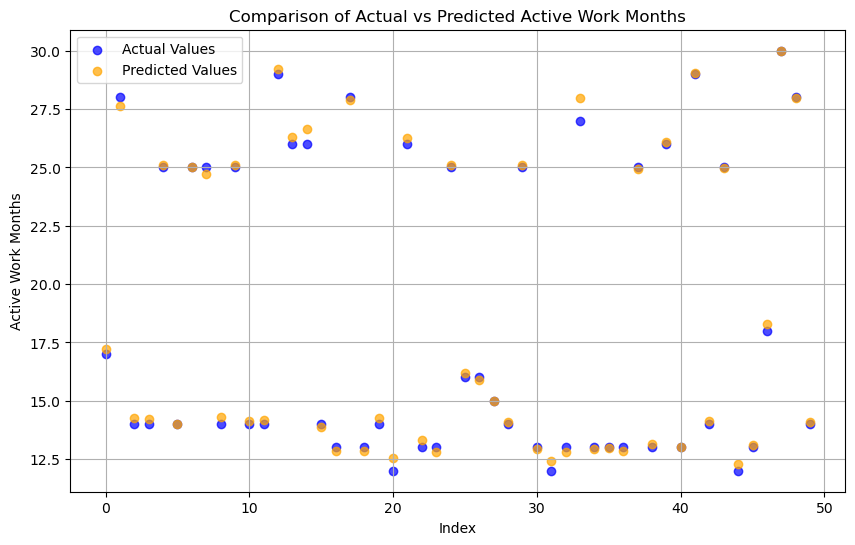

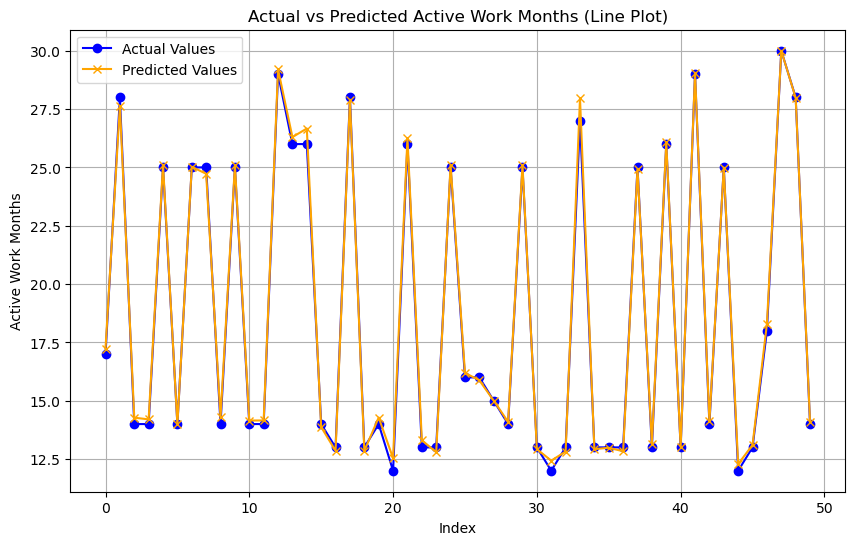

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Nilai aktual dan prediksi
y_actual = df_test['active_work_months']  # Nilai aktual dari active_work_months
y_pred = X_test['predicted_active_work']  # Nilai prediksi dari model regresi

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_actual)), y_actual, label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_actual)), y_actual, label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import pickle

with open('regression_model.sav', 'wb') as f:
    pickle.dump(final_model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [1]:
%pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/02/48/033ab9a2dee26d3de7e57cf532ab1d8408a608544c85ff98e6ea65775bdf/shap-0.46.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
    --------------------------------------- 10.2/456.1 kB ? eta -:--:--
   --------- ------------------------------ 112.6/456.1 kB 1.6 MB/s eta 0:00:01
   ------------------------------------ --- 419.8/456.1 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
